# First test with non-constant time
---

This study uses 1,100 images in the area bounded by 36N to 40N and 074W to 078W and 2020-05-25T22:00:00 to 2020-05-26T02:00:00.  Images are compressed to 224 x 224 pixels.

## Import useful packages

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, Dropout, Lambda, Concatenate, Flatten, concatenate
from tensorflow.keras import Model
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
import ktrain
import random

In [2]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
os.environ["CUDA_VISIBLE_DEVICES"]="0,1"; 

## Define functions to load the data


In [3]:
def load_image(image_path, dim=(224,224), channels=1):
    """
    Loads a single image as a Numpy array and resizes it as
    desired.  The default dimensions are consistent with
    those expected by the VGG models.  

    Args:
    image_path: str pointing to the file

    dim: Two-element tuple giving the desired height
         and width of the processed image

    Returns:
    image:  A single-channel Numpy array
    """
    if channels == 1:
        image = cv2.imread(image_path, 0)
    else:
        image = cv2.imread(image_path, 1)
    image = cv2.resize(image, dim)#, interpolation = cv2.INTER_AREA)
    return image

In [4]:
def build_input(image_dir, channels=1, dim=(224,224)):
    """
    Loads all of the images into a single numpy array.
    Assumes that there are 101 equally-spaced images
    spanning lattitudes from 35N to 45N.  

    Args:
        image_dir: str giving name of the image directory

    Returns:
    X:  A 3-dimensional numpy array containing the
        images. Image height and width are set by
        `load_images` and default to 224 x 224.

    y:  A 1-dimensional numpy array of target lattitudes.
    """
    X = []
    files = os.listdir(image_dir)
    for file in files:
        if file[-4:] == '.png':
            image_path = os.path.join(image_dir, file)
            image = load_image(image_path, channels=channels, dim=dim)
            X.append(image)
    return (np.array(X) / 255)

In [5]:
def build_labels(image_dir):
    """
    Parses file names to extract lat, long, and time.
    
    Args:
        image_dir: str giving name of the image directory
        
    Returns:
        numpy.array of lats and longs with dimensions
        len(image_dir) x 2
        
        numpy.array of times
    """
    files = os.listdir(image_dir)
    y = []
    times = []
    for file in files:
        if file[-4:] == '.png':
            file_split = file.split('+')
            lat = float(file_split[0])
            long = float(file_split[1])
            time = file_split[2].split('.')[0]
            y.append((lat, long))
            times.append(time)
    return np.array(y), np.array(times, dtype='datetime64')

In [6]:
def normalize_times(times):
    """
    Converts times to a float bounded by [0,1]
    
    Args:
        times: numpy.array with dtype datetime64
        
    Returns:
        numpy.array of decimal times bounded on [0,1]
    """
    time_range = (times.max() - times.min()).astype('float64')
    seconds_from_t0 = (times - times.min()).astype('float64')
    
    return seconds_from_t0 / time_range

In [7]:
def normalize_y(y):
    """
    Converts lats and longs to values bounded by [0,1]
    
    Args:
        y:  numpy.array of dimensions observations x 2
        
    Returns
        numpy.array: normalized values
        
        tuple: values needed by the Haversine loss function
    """
    lat_min = y[:,0].min()
    lat_range = y[:,0].max() - y[:,0].min()
    long_min = y[:,1].min()
    long_range = y[:,1].max() - y[:,1].min()
    
    y_norm = np.zeros(y.shape)
    
    y_norm[:,0] = (y[:,0] - lat_min) / lat_range
    y_norm[:,1] = (y[:,1] - long_min) / long_range
    
    return y_norm, (lat_min, lat_range, long_min, long_range)

In [8]:
def evaluate_model(learner, x_test, t_test, y_test,
                  x_train, t_train, y_train):
    y_hat = learner.model.predict([x_test, t_test])
    y_hat_train = learner.model.predict([x_train, t_train])

    plt.scatter(y_train[:,0], y_hat_train[:,0])
    plt.scatter(y_test[:,0], y_hat[:,0])
    plt.title('Predicted lat vs. True lat')
    plt.xlabel('True lat')
    plt.ylabel('Predicted lat')
    plt.show()

    plt.scatter(y_train[:,1], y_hat_train[:,1])
    plt.scatter(y_test[:,1], y_hat[:,1])
    plt.title('Predicted long vs. True long')
    plt.xlabel('True long')
    plt.ylabel('Predicted long')
    plt.show()

    print('train loss - ' + str(learner.model.history.history['loss'][-1]))
    print('val loss - ' + str(learner.model.history.history['val_loss'][-1]))

## Define the loss function

In [9]:
def haversine_loss(y_true, y_pred, denorm=(36.0, 4.0, -78.0, 4.0), R=3443.92):
    """
    Returns the mean squared haversine distance
    between arrays consisting of lattitudes and
    longitudes.
    
    Args:
        y_true:  Either an np.array or a tf.constant
                 of dimensions m x 2 where m in the
                 number of observations.  Each row is
                 an ordered pair of [lat, long].
                 
        y_pred:  Has the same form as y_true.
        
        dnorm:   A tuple of four values needed to
                 convert normalized lat and long back
                 to actual values.
        
        R:       Float giving the radius of the earth.
                 The default value is in nautical
                 miles.  Values in other units:
                 
                 kilometers    -> 6378.14
                 statute miles -> 3963.19
                 smoots        -> 3.748e+6
        
    Returns:
        tf.tensor of shape () and dtype float64 giving
        the mean square distance error using the
        haversine function.
    
    Examples:
    
        Input:
        y1     = np.array([[0, 0]])
        y_hat1 = np.array([[0, 180]])
        
        Expected result:
        (pi * R) ** 2 = 117059281.6 nm^2
        
        Input:
        y2     = np.array([[0, 0]])
        y_hat2 = np.array([[90, 0]])
        
        Expected result:
        (pi * R / 2) ** 2 = 29264820.4 nm^2
        
        Input:
        Portmsouth, VA to Rota, Spain
        y3     = tf.constant([[36.8354, -76.2983]])
        y_hat3 = tf.constant([[36.6237, -6.3601]])
        
        Expected result:
        37065212.0 km^2
        
    Notes:
        Closely follows the JS implmentation at
        https://www.movable-type.co.uk/scripts/latlong.html.
    """
    # Break inputs into lattitudes and longitudes for
    # convienience

    # Convert normalized lat and long into actuals
    lat_min, lat_range, long_min, long_range = denorm
    lat1  = y_true[:,0] * lat_range + lat_min
    lat2  = y_pred[:,0] * lat_range + lat_min
    long1 = y_true[:,1] * long_range + long_min
    long2 = y_pred[:,1] * long_range + long_min
    
    # Compute phis and lambdas 
    phi1 = lat1 * np.pi / 180
    phi2 = lat2 * np.pi / 180
    delta_phi    = (lat2 - lat1) * np.pi / 180
    delta_lambda = (long2 - long1) * np.pi / 180
    
    # Intermediate computations
    a = tf.square(tf.sin(delta_phi / 2)) + tf.cos(phi1) * tf.cos(phi2) * tf.square(tf.sin(delta_lambda / 2))
    c = 2 * tf.atan2(tf.sqrt(a), tf.sqrt(1 - a))
    
    # Compute distances
    d = R * c
    
    # Compute the mean squared distance (MSE)
    return tf.reduce_mean(d)

## Prepare the data

### Load the images

In [10]:
X = build_input('../data/small_with_time', channels=1)

In [11]:
X = np.expand_dims(X, 3)

In [12]:
X.shape

(1100, 224, 224, 1)

In [13]:
y, times = build_labels('../data/small_with_time')

In [14]:
y_norm, denorm = normalize_y(y)

In [15]:
test_size = 0.1
random_draw = np.random.uniform(low=0, high=1, size=len(X))

### Split into test and training sets

In [16]:
test_mask = random_draw <= test_size

In [17]:
norm_times = normalize_times(times)

x_test = X[test_mask]
y_test = y_norm[test_mask]
t_test = norm_times[test_mask]

x_train = X[~test_mask]
y_train = y_norm[~test_mask]
t_train = norm_times[~test_mask]

print(x_test.shape, y_test.shape, t_test.shape)
print(x_train.shape, y_train.shape, t_train.shape)

(124, 224, 224, 1) (124, 2) (124,)
(976, 224, 224, 1) (976, 2) (976,)


## A CNN model with multiple inputs
-------

In [30]:
input_image = Input(shape=x_train[0].shape)
input_time = Input(shape=times[0].shape)
i = Conv2D(filters=5, kernel_size=10, padding='same', activation='relu')(input_image)
i = Conv2D(filters=1, kernel_size=10, padding='same', activation='relu')(i)
i = Flatten()(i)
t = Flatten()(input_time)
ti = concatenate([i, t])
ti = Dense(256, activation='relu')(ti)
ti = Dropout(0.2)(ti)
outputs = Dense(2, activation='sigmoid')(ti)
#outputs = Dense(2)(ti)

In [31]:
model = Model(inputs=[input_image, input_time], outputs=outputs)

In [36]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 1) 0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 224, 224, 5)  505         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 224, 224, 1)  501         conv2d_2[0][0]                   
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None,)]            0                                            
____________________________________________________________________________________________

In [37]:
model.compile(optimizer='adam',
             loss=haversine_loss,
             metrics=[haversine_loss])

In [38]:
learner = ktrain.get_learner(model, train_data=([x_train, t_train], y_train),
                             val_data=([x_test, t_test], y_test))

simulating training for different learning rates... this may take a few moments...


/usr/local/lib/python3.6/dist-packages/ktrain/core.py:476: UserWarning: max_epochs is being set to 5 since steps per epoch is small. If you wish to estimate LR using more epochs, set max_epochs manually.
  'If you wish to estimate LR using more epochs, set max_epochs manually.')


Train on 976 samples
Epoch 1/5
976/976 [==============================] - 2s 2ms/sample - loss: 91.4486 - haversine_loss: 91.4655
Epoch 2/5
976/976 [==============================] - 1s 946us/sample - loss: 90.9121 - haversine_loss: 90.6547
Epoch 3/5
976/976 [==============================] - 1s 939us/sample - loss: nan - haversine_loss: nan
Epoch 4/5
976/976 [==============================] - 1s 941us/sample - loss: nan - haversine_loss: nan
Epoch 5/5
976/976 [==============================] - 1s 935us/sample - loss: nan - haversine_loss: nan
Call to keras.models.load_model failed.  Try using the learner.model.save_weights and learner.model.load_weights instead.
Error was: SavedModel file does not exist at: /tmp/tmpnrxhsz23/{saved_model.pbtxt|saved_model.pb}


done.
Visually inspect loss plot and select learning rate associated with falling loss


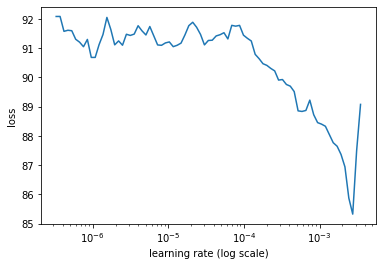

In [35]:
learner.lr_find(show_plot=True)

In [39]:
learner.autofit(10e-4)

early_stopping automatically enabled at patience=5
reduce_on_plateau automatically enabled at patience=2


begin training using triangular learning rate policy with max lr of 0.001...
Train on 976 samples, validate on 124 samples
Epoch 1/1024
976/976 [==============================] - 2s 2ms/sample - loss: 79.6818 - haversine_loss: 79.2937 - val_loss: 57.7493 - val_haversine_loss: 57.8456
Epoch 2/1024
976/976 [==============================] - 1s 1ms/sample - loss: 39.7212 - haversine_loss: 39.6850 - val_loss: 28.9658 - val_haversine_loss: 29.0701
Epoch 3/1024
976/976 [==============================] - 1s 1ms/sample - loss: 26.3340 - haversine_loss: 26.2161 - val_loss: 23.9572 - val_haversine_loss: 24.0476
Epoch 4/1024
976/976 [==============================] - 1s 1ms/sample - loss: 20.9475 - haversine_loss: 20.9006 - val_loss: 19.4501 - val_haversine_loss: 19.4859
Epoch 5/1024
976/976 [==============================] - 1s 1ms/sample - loss: 18.0981 - haversine_loss: 18.0658 - val_loss

### Evaluate the CNN model

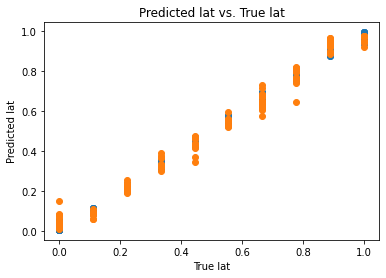

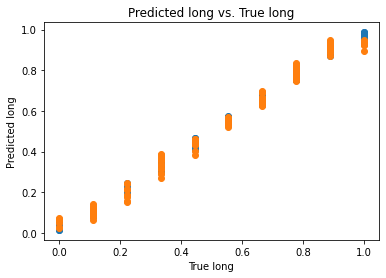

train loss - 5.609847498721764
val loss - 10.41181779676868


In [40]:
evaluate_model(learner, x_test, t_test, y_test, x_train, t_train, y_train)

In [45]:
model.save('../models/small_model')

In [46]:
model.save_weights('../models/small_model/checkpoint')